# Predicción de demanda con Amazon Forecast

Amazon Forecast es un servicio completamente administrado que permite generar predicciones muy precisas sobre series temporales. Este servicio está basado  en la misma tecnología que utiliza Amazon.com, y no requiere ninguna experiencia previa sobre aprendizaje automático.

Para poder utilizar Amazon Forecast, el usuario necesita proveer datos históricos de lo que busca predecir, así como cualquier otra información adicional que pueda impactar dicha predicción. Por ejemplo, la demanda por un tipo de zapato en particular puede variar acorde a la estación (verano, invierno, primavera, otoño) y por la ubicación de la tienda.

El servicio ofrece diferentes dominios, que definen un esquema pre-definido para diferentes casos de uso. Para este ejemplo, utilizaremos el dominio de RETAIL.

## Importando los datos al notebook

Haremos uso de un dataset público, disponible en [este enlace](https://www.kaggle.com/datasets/knightbearr/sales-product-data). Este es un dataset de ventas de productos, que contiene las fechas de venta, la cantidad de producto y el nombre del producto que fue vendido.

In [1]:
# clonando el dataset
! git clone https://github.com/andreamz05/forecast-sales_product_data.git

Cloning into 'forecast-sales_product_data'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 2.52 MiB | 2.47 MiB/s, done.
Resolving deltas: 100% (11/11), done.


## Pre-procesando los datos

In [130]:
# importando librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dateutil.parser
import glob
import os

In [3]:
cwd = os.getcwd()

In [4]:
cwd

'/home/ec2-user/SageMaker'

In [5]:
path = cwd + '/forecast-sales_product_data' 
all_files = glob.glob(os.path.join(path , "*.csv"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_all_data = pd.concat(li, axis=0, ignore_index=True)

In [6]:
df_all_data

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,248151,AA Batteries (4-pack),4,3.84,09/17/19 14:44,"380 North St, Los Angeles, CA 90001"
1,248152,USB-C Charging Cable,2,11.95,09/29/19 10:19,"511 8th St, Austin, TX 73301"
2,248153,USB-C Charging Cable,1,11.95,09/16/19 17:48,"151 Johnson St, Los Angeles, CA 90001"
3,248154,27in FHD Monitor,1,149.99,09/27/19 07:52,"355 Hickory St, Seattle, WA 98101"
4,248155,USB-C Charging Cable,1,11.95,09/01/19 19:03,"125 5th St, Atlanta, GA 30301"
...,...,...,...,...,...,...
186845,295660,AAA Batteries (4-pack),2,2.99,11/04/19 14:17,"574 4th St, Los Angeles, CA 90001"
186846,295661,USB-C Charging Cable,1,11.95,11/23/19 07:22,"359 1st St, Austin, TX 73301"
186847,295662,Lightning Charging Cable,1,14.95,11/13/19 16:12,"900 10th St, Boston, MA 02215"
186848,295663,AAA Batteries (4-pack),1,2.99,11/17/19 17:08,"592 Sunset St, Boston, MA 02215"


In [7]:
df_all_data = df_all_data.dropna() #limpiando el dataset

In [8]:
df_all_data.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


In [9]:
df_all_data = df_all_data[df_all_data.ne(df_all_data.columns).any(axis=1)]

In [10]:
df_all_data['Order Date'] = pd.to_datetime(df_all_data['Order Date'], format='%m/%d/%y %H:%M')

In [11]:
df_all_data

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,248151,AA Batteries (4-pack),4,3.84,2019-09-17 14:44:00,"380 North St, Los Angeles, CA 90001"
1,248152,USB-C Charging Cable,2,11.95,2019-09-29 10:19:00,"511 8th St, Austin, TX 73301"
2,248153,USB-C Charging Cable,1,11.95,2019-09-16 17:48:00,"151 Johnson St, Los Angeles, CA 90001"
3,248154,27in FHD Monitor,1,149.99,2019-09-27 07:52:00,"355 Hickory St, Seattle, WA 98101"
4,248155,USB-C Charging Cable,1,11.95,2019-09-01 19:03:00,"125 5th St, Atlanta, GA 30301"
...,...,...,...,...,...,...
186845,295660,AAA Batteries (4-pack),2,2.99,2019-11-04 14:17:00,"574 4th St, Los Angeles, CA 90001"
186846,295661,USB-C Charging Cable,1,11.95,2019-11-23 07:22:00,"359 1st St, Austin, TX 73301"
186847,295662,Lightning Charging Cable,1,14.95,2019-11-13 16:12:00,"900 10th St, Boston, MA 02215"
186848,295663,AAA Batteries (4-pack),1,2.99,2019-11-17 17:08:00,"592 Sunset St, Boston, MA 02215"


In [12]:
df_all_data = df_all_data.sort_values(by='Order Date')

In [13]:
df_all_data = df_all_data.rename(columns={'Order ID': 'order_id', 'Product': 'product', 'Quantity Ordered': 'demand', 'Price Each':'price_each', 'Order Date': 'order_date', 'Purchase Address': 'purchase_address'})

In [14]:
df_all_data

,order_id,product,demand,price_each,order_date,purchase_address
115035,147268,Wired Headphones,1,11.99,2019-01-01 03:07:00,"9 Lake St, New York City, NY 10001"
115845,148041,USB-C Charging Cable,1,11.95,2019-01-01 03:40:00,"760 Church St, San Francisco, CA 94016"
117198,149343,Apple Airpods Headphones,1,150,2019-01-01 04:56:00,"735 5th St, New York City, NY 10001"
117852,149964,AAA Batteries (4-pack),1,2.99,2019-01-01 05:53:00,"75 Jackson St, Dallas, TX 75001"
117205,149350,USB-C Charging Cable,2,11.95,2019-01-01 06:03:00,"943 2nd St, Atlanta, GA 30301"
...,...,...,...,...,...,...
152986,304165,AAA Batteries (4-pack),1,2.99,2020-01-01 04:13:00,"825 Adams St, Portland, OR 97035"
147705,299125,USB-C Charging Cable,1,11.95,2020-01-01 04:21:00,"754 Hickory St, New York City, NY 10001"
154739,305840,Bose SoundSport Headphones,1,99.99,2020-01-01 04:54:00,"784 River St, San Francisco, CA 94016"
149176,300519,Lightning Charging Cable,1,14.95,2020-01-01 05:13:00,"657 Spruce St, New York City, NY 10001"


In [15]:
df_all_data = df_all_data.astype({'order_id': int, 'demand': int, 'price_each': float})

In [16]:
df_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 115035 to 149175
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   order_id          185950 non-null  int64         
 1   product           185950 non-null  object        
 2   demand            185950 non-null  int64         
 3   price_each        185950 non-null  float64       
 4   order_date        185950 non-null  datetime64[ns]
 5   purchase_address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.9+ MB


In [17]:
demand = df_all_data.groupby(['order_date', 'product'])['demand'].sum().reset_index()

In [18]:
demand

,order_date,product,demand
0,2019-01-01 03:07:00,Wired Headphones,1
1,2019-01-01 03:40:00,USB-C Charging Cable,1
2,2019-01-01 04:56:00,Apple Airpods Headphones,1
3,2019-01-01 05:53:00,AAA Batteries (4-pack),1
4,2019-01-01 06:03:00,USB-C Charging Cable,2
...,...,...,...
181872,2020-01-01 04:13:00,AAA Batteries (4-pack),1
181873,2020-01-01 04:21:00,USB-C Charging Cable,1
181874,2020-01-01 04:54:00,Bose SoundSport Headphones,1
181875,2020-01-01 05:13:00,Bose SoundSport Headphones,1


Nota: Los atributos en nuestro set de datos para predicción de valores a futuro pueden tener cualquier nombre (no importa), sin embargo debe ir exactamente en ese orden: timestamp, item_id y valor a predecir. 

In [19]:
split_date = datetime.datetime(2019,10,31,23,59,59)

In [20]:
train = demand.loc[demand['order_date'] <= split_date]
test = demand.loc[demand['order_date'] > split_date]

In [21]:
train

,order_date,product,demand
0,2019-01-01 03:07:00,Wired Headphones,1
1,2019-01-01 03:40:00,USB-C Charging Cable,1
2,2019-01-01 04:56:00,Apple Airpods Headphones,1
3,2019-01-01 05:53:00,AAA Batteries (4-pack),1
4,2019-01-01 06:03:00,USB-C Charging Cable,2
...,...,...,...
140467,2019-10-31 23:38:00,AAA Batteries (4-pack),1
140468,2019-10-31 23:48:00,Macbook Pro Laptop,1
140469,2019-10-31 23:49:00,27in 4K Gaming Monitor,1
140470,2019-10-31 23:50:00,Flatscreen TV,1


In [22]:
test

,order_date,product,demand
140472,2019-11-01 00:00:00,AA Batteries (4-pack),1
140473,2019-11-01 00:09:00,AAA Batteries (4-pack),1
140474,2019-11-01 00:10:00,Bose SoundSport Headphones,1
140475,2019-11-01 00:24:00,AAA Batteries (4-pack),1
140476,2019-11-01 00:31:00,27in FHD Monitor,1
...,...,...,...
181872,2020-01-01 04:13:00,AAA Batteries (4-pack),1
181873,2020-01-01 04:21:00,USB-C Charging Cable,1
181874,2020-01-01 04:54:00,Bose SoundSport Headphones,1
181875,2020-01-01 05:13:00,Bose SoundSport Headphones,1


In [23]:
data_plot = train.copy()

In [24]:
data_plot['date'] = data_plot['order_date'].dt.strftime('%Y-%m')

In [25]:
data_plot

,order_date,product,demand,date
0,2019-01-01 03:07:00,Wired Headphones,1,2019-01
1,2019-01-01 03:40:00,USB-C Charging Cable,1,2019-01
2,2019-01-01 04:56:00,Apple Airpods Headphones,1,2019-01
3,2019-01-01 05:53:00,AAA Batteries (4-pack),1,2019-01
4,2019-01-01 06:03:00,USB-C Charging Cable,2,2019-01
...,...,...,...,...
140467,2019-10-31 23:38:00,AAA Batteries (4-pack),1,2019-10
140468,2019-10-31 23:48:00,Macbook Pro Laptop,1,2019-10
140469,2019-10-31 23:49:00,27in 4K Gaming Monitor,1,2019-10
140470,2019-10-31 23:50:00,Flatscreen TV,1,2019-10


<AxesSubplot:xlabel='date', ylabel='demand'>

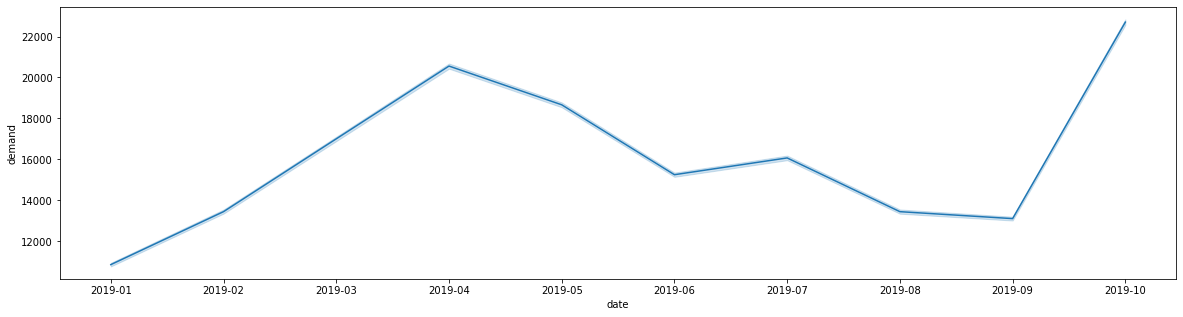

In [26]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(20,5))

sns.lineplot(x="date", y="demand", data=data_plot, estimator=np.sum)

In [27]:
data_plot = test.copy()

In [28]:
data_plot['date'] = data_plot['order_date'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='date', ylabel='demand'>

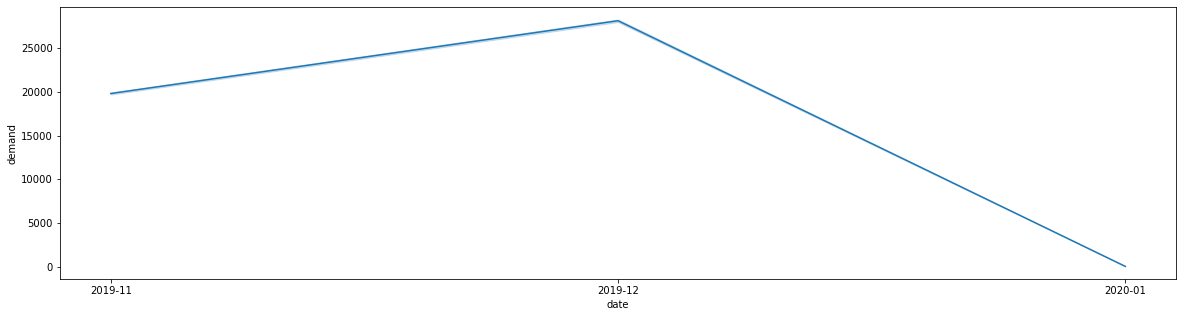

In [29]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(20,5))

sns.lineplot(x="date", y="demand", data=data_plot, estimator=np.sum)

## Subir datos a S3

In [30]:
import boto3
import sagemaker
s3 = boto3.client("s3", region_name='us-east-1')
bucket_name='forecast-test-ventas-10102022'
bucket = s3.create_bucket(Bucket=bucket_name)

In [31]:
train.to_csv('train_demand.csv', index=False)

In [32]:
s3.upload_file(Filename="train_demand.csv", Bucket=bucket_name, Key="train_demand.csv")

## Creando el predictor

In [35]:
# Definicion de variables
dataset_group_name = "forecast_demanda_group"
dataset_name = "demanda_dataset"
dataset_import_job = 'demanda_dataset_job'
predictor_name = 'predictor_demanda'
forecast_name = 'demanda_forecast'

In [34]:
role = sagemaker.get_execution_role()
iam = boto3.client('iam')
forecast = boto3.client('forecast', region_name='us-east-1')

In [36]:
# Creando el dataset de forecast
dataset_response = forecast.create_dataset(
    DatasetName=dataset_name,
    Domain='RETAIL',
    DatasetType="TARGET_TIME_SERIES",
    DataFrequency="D",
    Schema={
        "Attributes": [
            {"AttributeName": "timestamp", "AttributeType": "timestamp"},
            {"AttributeName": "item_id", "AttributeType": "string"},
            {"AttributeName": "demand", "AttributeType": "float"},
        ]
    },
)

In [37]:
dataset_response

{'DatasetArn': 'arn:aws:forecast:us-east-1:xxxxxxxxxxxx:dataset/demanda_dataset',
 'ResponseMetadata': {'RequestId': '98d89f23-2c1a-4370-bf4f-e2f18c0760bb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 11 Oct 2022 06:18:18 GMT',
   'x-amzn-requestid': '98d89f23-2c1a-4370-bf4f-e2f18c0760bb',
   'content-length': '80',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [38]:
# Crear import job
import_job_response = forecast.create_dataset_import_job(
    DatasetImportJobName=dataset_import_job,
    DatasetArn=dataset_response["DatasetArn"],
    DataSource={
        "S3Config": {
            "Path": f"s3://{bucket_name}/",
            "RoleArn": role,
        }
    },
    TimestampFormat="yyyy-MM-dd HH:mm:ss"
)

In [39]:
# Creando un dataset group
dataset_group_response = forecast.create_dataset_group(
    DatasetGroupName=dataset_group_name,
    Domain='RETAIL',
    DatasetArns=[dataset_response["DatasetArn"]],
)

In [40]:
dataset_group_response

{'DatasetGroupArn': 'arn:aws:forecast:us-east-1:xxxxxxxxxxxx:dataset-group/forecast_demanda_group',
 'ResponseMetadata': {'RequestId': 'dd88527e-904b-4fee-93f7-d4567ce7090a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 11 Oct 2022 06:20:21 GMT',
   'x-amzn-requestid': 'dd88527e-904b-4fee-93f7-d4567ce7090a',
   'content-length': '98',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

El trabajo de importación puede tardar varios minutos en completarse, dependiendo del tamaño del dataset. Con la siguiente celda se puede revisar el progreso

In [44]:
import_status = forecast.describe_dataset_import_job(
DatasetImportJobArn=import_job_response['DatasetImportJobArn']
)
import_status['Status']

'ACTIVE'

In [45]:
# Create predictor using automl
predictor_response = forecast.create_predictor(
    PredictorName=predictor_name,
    ForecastHorizon=30,
    PerformAutoML=True,
    PerformHPO=False,
    InputDataConfig={"DatasetGroupArn": dataset_group_response["DatasetGroupArn"]},
    FeaturizationConfig={"ForecastFrequency": "D"},
)

In [46]:
predictor_response

{'PredictorArn': 'arn:aws:forecast:us-east-1:xxxxxxxxxxxx:predictor/predictor_demanda',
 'ResponseMetadata': {'RequestId': '8a895b8d-41f2-4043-8d7a-57816c839ffe',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 11 Oct 2022 06:36:11 GMT',
   'x-amzn-requestid': '8a895b8d-41f2-4043-8d7a-57816c839ffe',
   'content-length': '86',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

El predictor demora en crearse dependiendo del volumen de los datos. Podemos revisar el status con la siguiente celda

In [55]:
describe_predictor = forecast.describe_predictor(
    PredictorArn=predictor_response['PredictorArn']
)
describe_predictor['Status']

'ACTIVE'

In [56]:
# Crear forecast
forecast_response = forecast.create_forecast(
    ForecastName=forecast_name,
    PredictorArn=predictor_response["PredictorArn"],
    ForecastTypes=["0.1", "0.5", "0.9"],
)

In [57]:
forecast_response

{'ForecastArn': 'arn:aws:forecast:us-east-1:xxxxxxxxxxxx:forecast/demanda_forecast',
 'ResponseMetadata': {'RequestId': '6778a58f-9691-44d1-bfbb-f7d49b39a647',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 11 Oct 2022 15:45:52 GMT',
   'x-amzn-requestid': '6778a58f-9691-44d1-bfbb-f7d49b39a647',
   'content-length': '83',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

El forecast tarda alrededor de 20 minutos en crearse, podemos revisar el estado con la siguiente celda

In [60]:
describe_forecast = forecast.describe_forecast(
    ForecastArn=forecast_response['ForecastArn']
)
describe_forecast['Status']

'ACTIVE'

In [62]:
# Crear trabajo de exportación
export_job = forecast.create_forecast_export_job(
    ForecastExportJobName="DemandaForecast01",
    ForecastArn=forecast_response["ForecastArn"],
    Destination={
        "S3Config": {
            "Path": f's3://{bucket_name}',
            "RoleArn": role,
        }
    },
)

In [63]:
export_job

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-1:xxxxxxxxxxxx:forecast-export-job/demanda_forecast/DemandaForecast01',
 'ResponseMetadata': {'RequestId': '79eb282d-3130-45e7-a4c3-e240f9c94d0c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 11 Oct 2022 16:06:30 GMT',
   'x-amzn-requestid': '79eb282d-3130-45e7-a4c3-e240f9c94d0c',
   'content-length': '121',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Obteniendo una predicción

In [151]:
PREDICCION_ITEM = 'USB-C Charging Cable'

In [152]:
forecastquery = boto3.client('forecastquery', region_name='us-east-1')

In [153]:
forecastPredictionResponse = forecastquery.query_forecast(
    ForecastArn=forecast_response["ForecastArn"],
    Filters={"item_id": PREDICCION_ITEM}
)

## Graficando la predicción

In [154]:
# Generar DF 
prediction_df_p10 = pd.DataFrame.from_dict(forecastPredictionResponse['Forecast']['Predictions']['p10'])
prediction_df_p10.head()

,Timestamp,Value
0,2019-11-01T00:00:00,45.0
1,2019-11-02T00:00:00,38.0
2,2019-11-03T00:00:00,41.0
3,2019-11-04T00:00:00,44.0
4,2019-11-05T00:00:00,47.0


<AxesSubplot:>

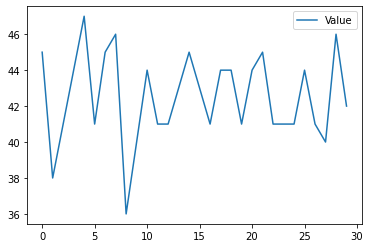

In [155]:
prediction_df_p10.plot()

In [156]:
prediction_df_p50 = pd.DataFrame.from_dict(forecastPredictionResponse['Forecast']['Predictions']['p50'])
prediction_df_p90 = pd.DataFrame.from_dict(forecastPredictionResponse['Forecast']['Predictions']['p90'])

## Mostrando los valores reales

In [157]:
# Los valores reales de demanda de cada producto, estan en el dataset de test
actual_df = (test[(test['order_date'] > datetime.datetime(2019,10,31,23,59,59)) & (test['order_date'] <= datetime.datetime(2019,11,30,23,59,59))]).copy()

In [158]:
actual_df = actual_df.loc[actual_df['product'] == PREDICCION_ITEM]

In [159]:
actual_df.order_date = actual_df.order_date.dt.normalize()

In [160]:
actual_df = actual_df.groupby(['order_date','product']).sum().reset_index()

In [161]:
actual_df = actual_df.astype( {'order_date': str})

In [162]:
prediction_df_p10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  30 non-null     object 
 1   Value      30 non-null     float64
dtypes: float64(1), object(1)
memory usage: 608.0+ bytes


In [163]:
actual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   order_date  30 non-null     object
 1   product     30 non-null     object
 2   demand      30 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 848.0+ bytes


In [164]:
actual_df = actual_df.drop(['product'], axis=1)

In [165]:
actual_df

,order_date,demand
0,2019-11-01,83
1,2019-11-02,82
2,2019-11-03,74
3,2019-11-04,72
4,2019-11-05,83
5,2019-11-06,72
6,2019-11-07,83
7,2019-11-08,83
8,2019-11-09,69
9,2019-11-10,65


In [166]:
# Para igualar el df de la predicción
actual_df = actual_df.rename(columns={'order_date': 'timestamp', 'demand': 'value'})

## Comparando la predicción con los resultados

In [167]:
results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])

In [168]:
for index, row in actual_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['value'], 'source': 'actual'} , ignore_index=True)

In [169]:
for index, row in prediction_df_p10.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in prediction_df_p50.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in prediction_df_p90.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

In [170]:
results_df

,timestamp,value,source
0,2019-11-01,83,actual
1,2019-11-02,82,actual
2,2019-11-03,74,actual
3,2019-11-04,72,actual
4,2019-11-05,83,actual
...,...,...,...
115,2019-11-26,78.0,p90
116,2019-11-27,83.0,p90
117,2019-11-28,83.0,p90
118,2019-11-29,79.0,p90


In [171]:
pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")

pivot_df

source,actual,p10,p50,p90
timestamp,,,,
2019-11-01,83,45.0,55.0,74.0
2019-11-02,82,38.0,58.0,83.0
2019-11-03,74,41.0,61.0,83.0
2019-11-04,72,44.0,64.0,82.0
2019-11-05,83,47.0,57.0,79.0
2019-11-06,72,41.0,56.0,75.0
2019-11-07,83,45.0,62.0,91.0
2019-11-08,83,46.0,58.0,79.0
2019-11-09,69,36.0,63.0,88.0


<AxesSubplot:xlabel='timestamp'>

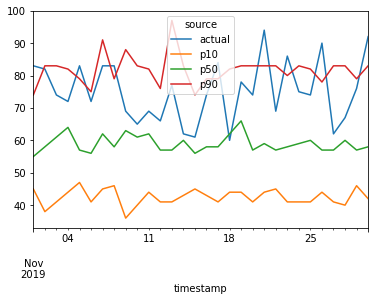

In [172]:
pivot_df.plot()

## Limpieza

Al terminar podemos eliminar los recursos de Forecast con las siguientes celdas

In [ ]:
# Borrar el forecast
delete_forecast = forecast.delete_forecast(
    ForecastArn=forecast_response['ForecastArn']
)

In [ ]:
delete_forecast

In [ ]:
# Borrar el predictor
delete_predictor = forecast.delete_predictor(
    PredictorArn=predictor_response['PredictorArn']
)

In [ ]:
delete_predictor

In [ ]:
# Borrar el trabajo de exportación
delete_export_job = forecast.delete_forecast_export_job(
    ForecastExportJobArn=export_job['ForecastExportJobArn']
)

In [ ]:
delete_export_job

In [ ]:
# Borrar el dataset import job
delete_dataset_import_job = forecast.delete_dataset_import_job(
    DatasetImportJobArn=import_job_response['DatasetImportJobArn']
)

In [ ]:
delete_dataset_import_job

In [ ]:
# Borrar el dataset
delete_dataset = forecast.delete_dataset(
    DatasetArn=dataset_response['DatasetArn']
)

In [ ]:
delete_dataset

In [ ]:
# Borrar el dataset group
delete_dataset_group = forecast.delete_dataset_group(
    DatasetGroupArn=dataset_group_response["DatasetGroupArn"]
)

In [ ]:
delete_dataset_group